# Vehicle Detection and Tracking

This notebook serves as both code solution and writeup.

The rubric points and associated code will be addressed in both markup and acccompanyting code cell sections.

The goals of this project are:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
* Optionally, apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Normalize the features
* Randomize a selection for training and testing.
* Implement a sliding-window technique
* Use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream
* Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Setup imports and globals

In [2]:
import matplotlib.pyplot as plt
from search_classify import *
from lesson_functions import *
%matplotlib inline  

training_small = False
debug = False;

## Read in the training data

The following code cell reads from two data sources. One is much smaller and was used for early testing, while the second is larger and was used promarily after the basics of traing a model were accomplished.

In [3]:
# Read in cars and notcars
images = glob.glob('training/**/*.jpeg', recursive=True)

if training_small:
    car_images = glob.glob('training/vehicles_smallset/*/*.jpeg')
    notcar_images = glob.glob('training/non-vehicles_smallset/*/*.jpeg')
else:
    car_images = glob.glob('training/vehicles/*/*.png')
    notcar_images = glob.glob('training/non-vehicles/*/*.png')

cars = []
notcars = []

for img in car_images:
    cars.append(img)
                
for img in notcar_images:
    notcars.append(img)
 
if debug:
    print("training with {} images, labelled as cars".format(len(cars)))
    print("training with {} images, not labelled as cars".format(len(notcars)))


## Identify parameters to be used

As introduced in the course, features were extracted by evalauting: histogram of oriented gradients (HOG), a color transform with binned color features, and a histogram of colors for each training image.   

The parameters in the following cell were selected mostly through trial and error manipulation of the values provided in the course materials, resulting in test accuracy of 98.9%.


In [4]:
color_space = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9               # HOG orientations
pix_per_cell = 8         # HOG pixels per cell
cell_per_block = 2       # HOG cells per block
hog_channel = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 32           # Number of histogram bins
spatial_feat = True      # Spatial features on or off
hist_feat = True         # Histogram features on or off
hog_feat = True          # HOG features on or off

## Extract Features and unroll in into training and labeled vectors

Once the features were extracted for our 'car'/'not cars' training sets, the features were appened and unrolled for subsequent model training. Correspondingly, labels were similarlay appended. Next, the feature data was normalized using sklearn's StandardScalar function. This is performed to remove the mean (setting it to zero) and establish to extablish unit variance, a practice commonly with SVN classifiers to improve overall performance.

In order to prevent StandardScalar()'s fit function from raising NaN exceptions, NaNs were coerced to 0.

In [5]:
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

print("features extracted") 

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X = np.nan_to_num(X)                     ## coercion: needed to avoid NaN errors
X_scaler = StandardScaler().fit(X)       ## Fit a per-column scaler
scaled_X = X_scaler.transform(X)         ## Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels 

print("features and labels stacked and scaled.")

/Users/ggcstaff/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


features extracted
features and labels stacked and scaled.


## Divide training data into training and test subsets

It is recognized that it would have been better to first separate the data in some whay so that similar frames wouldnt appear in both training and test data sets. Since it appears that things went ok without doing that step, it was not pursued.


In [6]:
rand_state = np.random.randint(0, 100)   ## Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156


## Train a SVM model

In [7]:
svc = LinearSVC()                       ## Use a linear SVC
t = time.time()                         ## Check the training time for the SVC
svc.fit(X_train, y_train)               ## train the model
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

15.84 Seconds to train SVC...
Test Accuracy of SVC =  0.987


# Image Pipeline

## Define it

The pipeline is created to visit subsections of each frame at a fixed size. Subsections are overlapped and evaluated to look for occurences of either 'car' or 'not car' labels as found in the SVM model. 

The image is processed with three different sizes of window: 48, 72, and 128. For each subsection size, limited bands are searched. For example, it makes no sense to look for car images in the 48x48 size range in the sky or at the very bottom of the screen. Similar boundaries are established for each of the other two sliding window sizes. The sliding window code appears in the following cell. Final values for sliding image size, overlap, and upper/low bounds were found by trial and error.

The find_window function returns a list of all matching (aka 'hot') windows along with an annotated image.

The following code cell provides an example input image with resulting annotations.



In [8]:
def find_windows(image, type="jpg"):
    
    global y_start_stop
    
    if image.shape[2] == 4:
        red, green, blue  = (1,0,0,1), (0,1,0,1), (0,0,1,1)
    else: 
        red, green, blue  = (255,0,0), (0,255,0), (0,0,255)  ## img.shape[2] must equal 3
        
    draw_image = np.copy(image)

    if not training_small and type == "jpg": ## scales 0..255 to 0..1
        image = image.astype(np.float32)/255

    if training_small and type == "png": ## scales 0.0..1.0 to 0..255
        image = img_as_ubyte(image)

    all_windows_list = []
    window_params = [
        [[700, image.shape[1]],
         [y_start_stop[0], y_start_stop[1]],
         [0.8,0.8],
         [48,48],
         red],
        [[700, image.shape[1]],
         [y_start_stop[0], y_start_stop[1]],
         [0.7,0.7],
         [72,72],
         blue],
        [[700, image.shape[1]],
         [y_start_stop[0], y_start_stop[1]],
         [0.8,0.8],
         [128,128],
        green]
    ]
                    
    for iteration in range(len(window_params)):
        
        x_start_stop = window_params[iteration][0]
        y_start_stop = window_params[iteration][1]
        xy_overlap = window_params[iteration][2]
        xy_window = window_params[iteration][3]
        boundary_color = window_params[iteration][4]

        if debug:
            print("draw image shape = {}".format(draw_image.shape))
            print("x_start_stop = {}".format(x_start_stop))
            print("y_start_stop = {}".format(y_start_stop))
            cv2.line(draw_image, (0, y_start_stop[0]),(draw_image.shape[1], y_start_stop[0]),
                     boundary_color, thickness=2)
            cv2.line(draw_image, (0, y_start_stop[1]),(draw_image.shape[1], y_start_stop[1]),
                     boundary_color, thickness=2)
            print("xy_window = {}".format(xy_window))
            print("xy_overlap = {}".format(xy_overlap))
            print("boundary color = {}".format(boundary_color))
            
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                           xy_window=xy_window, xy_overlap=xy_overlap)

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)
        all_windows_list.extend(hot_windows)
    
    return all_windows_list, draw_image

## Test pipeline on a png image

/Users/ggcstaff/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


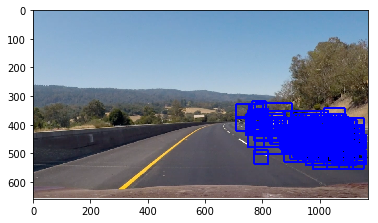

In [9]:
from skimage import img_as_ubyte

# Check the prediction time for a single sample
t = time.time()

file_name = 'examples/car-recognition-buck.png'
y_start_stop = [300, 600]  # Min and max in y to search in slide_window()
image = mpimg.imread(file_name)
all_windows_list, draw_img = find_windows(image, type="png")

window_img = draw_boxes(draw_img, all_windows_list, color=(0, 0, 1, 1), thick=6)

if debug:
    print(round(time.time() - t, 2), 'Seconds to search for vehicles')

plt.imshow(window_img)

## Test pipeline on a jpg image

The following code cell provides another example of find_windows(), this time using a jog file as input. This is important to establsih since the VideoFileClip class produces jpg images.

/Users/ggcstaff/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


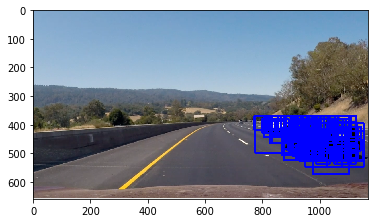

In [10]:
from skimage import img_as_ubyte

# Check the prediction time for a single sample
t = time.time()

file_name = 'examples/bbox-example-image.jpg'
y_start_stop = [370, 600]  # Min and max in y to search in slide_window()
all_windows_list, draw_img = find_windows(image, type="jpg")

window_img = draw_boxes(draw_img, all_windows_list, color=(0, 0, 1, 1), thick=6)

if debug:
    print(round(time.time() - t, 2), 'Seconds to search for vehicles')

plt.imshow(window_img)

## Add heat map and thresholding

Following the examples provided in the course, a heatmap can be generated to depict where two or more sliding window search results overlap. These are extremely useful since they indicate likely locations of vehicles. 

Sometimes, windows are detected that do not contain any vehicles. By filtering these areas (having lower 'heat' in the heatmap) we can eliminate false positives. This is the purpose of the apply_threshold method, shown below. 

The add_heat method is use to accumulate evidence of detections; the draw_labelled_boxes merthod displays aggregated heatmap results.

In [11]:
# from course module "37. Multiple Detections and False Positives"

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, type="jpg"):
    global detections
    bb_color = (0,0,255) if type=="jpg" else (0,0,1,1)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        credible = detections.update(bbox)
        ##if credible:
        cv2.rectangle(img, bbox[0], bbox[1], bb_color, 6)
    # Return the image
    return img

## Generate and consolidate heatmap into bounding boxes

With multiple sliding window passes at multiple sizes, it's commom to accumulate many overlapping potential vehicle boundary boxes. Fortunately, scipy offers a method to summarize multiple overlapping boundaries into a smaller number of enclosed polygons. The labelImage() method, taken from the course materials, performs this graphical reduction for us.

In [12]:
from scipy.ndimage.measurements import label

def labelImage(image, windows_list, type="jpg"):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    if debug:
        print("heatmap dim = {}".format(heat.shape))

    # Add heat to each box in box list
    heat = add_heat(heat, windows_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1.5)

    # Visualize the heatmap when diplaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels, type=type)
    
    return heatmap, draw_img

# Define utility classes to record and manipulate detections

In addition to analyzing each video frame, consecutive frames can be analyzed to determine the movement (and velocity) of vehicle boundaries. Centroids of the bounding boxes are calculated and tracked across multiple frames. Future vehicle locations can be predicted and substituted for more expensive frame-by-frame analysis, on a limited basis. The classes in the following code cell, Detection()and Detections(), track and analyze a stream consecutitve frames.

Moving averages for centroid location are used to determine velocity and predict future locations of vehicles.

In addition to the functions described above, the Detections() class will also periodically sweep for dormant detections and remove them accordingly.



In [13]:
from collections import deque
from scipy.spatial import distance

class Detection(object):
        
    def __init__(self, bbox):
        self.bbox = bbox
        self.history = deque(maxlen=5)
        self.centroid = self.calc_centroid()
        self.history.append(self.centroid)
        self.last_seen = time.time()
        self.credible = False
        
    def calc_centroid(self):
        δx = self.bbox[0][1] - self.bbox[0][0]
        δy = self.bbox[1][1] - self.bbox[1][0]
        return [δx/2, δy/2]
        
    def update(self, bbox):
        self.bbox = bbox
        self.centroid = self.calc_centroid()
        self.history.append(self.centroid)
        self.last_seen = time.time()
        
    def extrapolate(self, image, delta_frames, type="jpg"):
        
        bb_color = (0,0,100) if type=="jpg" else (0,0,1,1)
        if self.credible: # disregard id false positive is suspected
            v = self.get_velocity()
            temp_bbox =(
                (int(self.bbox[0][0] + (v[0]) * delta_frames), int(self.bbox[0][1] + (v[1]) * delta_frames)),
                (int(self.bbox[1][0] + (v[0]) * delta_frames), int(self.bbox[1][1] + (v[1]) * delta_frames))
                )
            cv2.rectangle(image, temp_bbox[0], temp_bbox[1], bb_color, 6)
        return image;
        
    def get_velocity(self):
        history_length = len(self.history)
        total_x_diffs = 0
        total_y_diffs = 0
        if history_length <= 1:
            return (0,0)
        else:
            for i in range(history_length):
                last = self.history[i-1]
                prev = self.history[i-2]
                total_x_diffs += last[0] - prev[0]
                total_y_diffs += last[1] - prev[1]                                                                                                                                 
        return (total_x_diffs / history_length, total_y_diffs / history_length)
    
class Detections(object):   ## class to track detections
    
    centroid_threshold = 15 ## pixels
    age_threshold = 1       ## seconds
        
    def __init__(self):
        self.detection_list = []
        credible = False
        
    def update(self, bbox):
        credible = False
        possibleDetection = Detection(bbox)
        for car_item in self.detection_list:
            if (distance.euclidean(possibleDetection.centroid, car_item.centroid) < 
                self.centroid_threshold):
                car_item.update(bbox)
                credible = True
                car_item.credible = credible
        if not credible:
            self.detection_list.append(possibleDetection)
        return credible
    
    def extrapolate(self, image, delta_frames, type='jpg'):
        self.remove_aged()
        for car_item in self.detection_list:
            car_item.extrapolate(image, delta_frames, type)
        return image
    
    def remove_aged(self):
        cleaned_list = []
        for car_item in self.detection_list:
            if time.time() - car_item.last_seen <= self.age_threshold:
                cleaned_list.append(car_item)
        self.detection_list = cleaned_list

## Test pipeline and heatmap processing on jpg test image

Now that we've established a pipeline and heatmap analysis, a spot test is created to test it out on a single frame.

/Users/ggcstaff/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


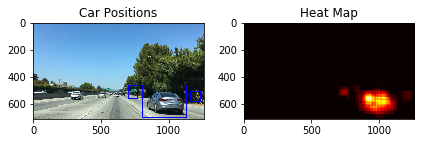

In [14]:
file_name = 'examples/bbox-example-image.jpg'
image = mpimg.imread(file_name)
y_start_stop = [420, 700]  # Min and max in y to search in slide_window()
all_windows_list, draw_img = find_windows(image, type="jpg")
past_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
detections = Detections()
heatmap, draw_img = labelImage(image, all_windows_list, type="jpg")

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Test pipeline and heatmap processing on png test image 

Let's recreate the same test scenario, this time on a png image.

/Users/ggcstaff/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


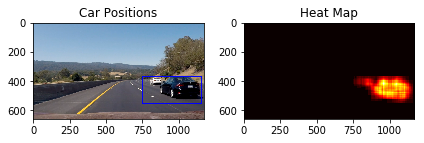

In [15]:
file_name = 'examples/car-recognition-buck.png'
image = mpimg.imread(file_name)
y_start_stop = [370, 600]  # Min and max in y to search in slide_window()
all_windows_list, draw_img = find_windows(image, type="png")
past_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
detections = Detections()
heatmap, draw_img = labelImage(image, all_windows_list, type="png")

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


## Test pipeline and heatmap processing on jpg test image from project video

The following test uses another jpg file, this time extracted from the projects's test video.

/Users/ggcstaff/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


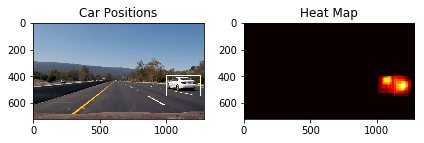

In [16]:
file_name = 'examples/image50.jpg'
image = mpimg.imread(file_name)
y_start_stop = [370, 600]  # Min and max in y to search in slide_window()
all_windows_list, draw_img = find_windows(image, type="jpg")
detections = Detections()
heatmap, draw_img = labelImage(image, all_windows_list, type="jpg")

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Create image processor to be used on each frame in video

The video clip processor requires a function that performs vehicle detection on each frame. Here, I call this function process_image(). process_image appears in the next code cell. 

process_image() also keeps track of subsequent frames. With this information, it will intervene on some frames and simply extrapolate new locations based on prior position and velocity. After a predetermined period, process_image() will reanalyze an entire frame and use this as a basis before returning to extrapolation again. As programmed in the next code cell below, process_image() will fully analyze each fifth frame and extrapolate each intervening four. When viewing the final view below, note that the darker blue vehicle boundary pulses are fully-processed frames, while the brighter blue frames are extrapolated. 

Using a five frame interval reduced processing time while not appearing to reduce recogntion accuracy. 

In [19]:
image_counter = 0

def process_image(image):
    global image_counter
    
    # re-find and re-label every 5th frame, extrapolate in between
    if image_counter % 9 == 0:
        win_list, img = find_windows(np.copy(image), type="jpg")
        heatmap, draw_image = labelImage(image, win_list, type="jpg")
    else:
        draw_image = detections.extrapolate(image, image_counter % 9, type="jpg")
    image_counter = image_counter + 1
    return draw_image

# Finally, automation for video processing

In [ ]:
from moviepy.editor import VideoFileClip, concatenate_videoclips # needed to edit/save/watch video clips
from IPython.display import HTML

output = 'output_videos/vehicle_detection.mp4'

file_name = 'examples/image50.jpg'
image = mpimg.imread(file_name)
past_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
y_start_stop = [370, 600]  # Min and max in y to search in slide_window()

if debug: ## troubleshoot
    v_clip1 = VideoFileClip("project_video.mp4").subclip(8,9)
    v_clip2 = VideoFileClip("project_video.mp4").subclip(22,23)
    v_clip3 = VideoFileClip("project_video.mp4").subclip(33,38)
    v_clip = concatenate_videoclips([v_clip1,v_clip2,v_clip3])
else: ## don't troublshoot
    v_clip = VideoFileClip("project_video.mp4")

detections = Detections()
clip = v_clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

HTML("""<video width="640" height="360" controls><source src="{0}"></video>""".format(output))

[MoviePy] >>>> Building video output_videos/vehicle_detection.mp4
[MoviePy] Writing video output_videos/vehicle_detection.mp4


 95%|█████████▍| 1196/1261 [13:53<00:35,  1.82it/s]

# Discussion


## General 

In general, I was able to follow the course lectures and assemble a pipeline and videostream processor that accomplishes the goals for the assignment.


## Problems

I really didn't run into too many problems. Reflecting, these were the biggest:

* time - it took me a while to get through this project. I feel that I would have progressed more rapidly if I had larger contiguous blocks of time to work on it, but my schedule has not permitted that lately.
*  discrepancies - I feel that I slend a lot of time ironing out the discrepancies in the python development environment. For example, using OpenCV colors versus Matplotlib colors, color vectors varying between 3 and 4 in length, ints versus floats, and np.array versus native python lists to name a few. It would be great if the platform was significantly more consistent.
* course material discrepancies -- sometimes it feels like this otherwise excellent course is a hodgepodge of other Udacity offerings. As a result, some material gets duplicated while other material simply just appears. For example, I hadn't heard at all about 'hard negative mining' until I read the rubric for this assignment. Was that covered before? Could be and I missed it, but I was surprised when first reading about that while submitting this assigment. In addition, it seems that examples, quizzes and projects commonly use similar but conflicting code examples. Perhaps that's intentional, but I foind it to be very distracting. I feel as if I spend more time refining my python skills than I do learning and refining my ML and CarND skills.
 
## Improvements and future work

I suspect that this model will break down as it's introduced to other test and real life scenarios. Perhaps different lighting and shadows, types of vehicles (trucks, motorcycles, lorries, construction equipment, etc.), two lane highwsys, highways with oncoming traffic, and residential streets could all introduce missed detections.  

To mitigate, I would:
* introduce more training data
* test across more test scenarios
* combine with deep learning. For example, consider a 1957 Chevy, Bugatti Chiron or 1920 Model T Ford. Without associated training data, a SVM or decision tree may fail to detect. However, with deep learning, we can get the benefits of 'duck-typing', where a deep net might recognize  the Chevy, Bugatti or Model T as cars, since they have wheels, a body, tail lights, shiny glass, etc. (That is of course, if the Bugatti doesn's simply appear as a blur in the image!)

